In [25]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_log_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.metrics import make_scorer, r2_score

from sklearn.linear_model import RidgeCV, Ridge
import numpy as np
from sklearn.datasets import make_regression
from sklearn.metrics import make_scorer
scoring_func = make_scorer(mean_squared_log_error,greater_is_better=False)



from csv_reader import *
from csv_setup import *


In [26]:
import numpy as np
from numpy.random import default_rng
rng = default_rng()

import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, Ridge
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
scoring_func = make_scorer(mean_squared_error,greater_is_better=False)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300


# import pandas as pd
# from itertools import combinations
# from more_itertools import powerset
# import operator

In [27]:
from sklearn.preprocessing import MinMaxScaler

# This function will normalize the count column
# This will decrease the variance, and therefore reduce the Test MSE

def get_bike_sharing_df_clean_mod():
    # Copy orig to new df
    bike_sharing_df_orig = get_bike_sharing_df_clean()
    bike_sharing_df = bike_sharing_df_orig.copy()
    
    values = bike_sharing_df.values    
    scaler = MinMaxScaler()
    values_scale = scaler.fit_transform(values)
    temp_df = pd.DataFrame(values_scale)
    
    
    bike_sharing_df['cnt'] = temp_df[7]
    
    return bike_sharing_df

In [28]:
# If you want to see the normalized results uncomment line 2 and comment line 4
# bike_sharing_df = get_bike_sharing_df_clean_mod()

bike_sharing_df = get_bike_sharing_df_clean()


print("Columns of the dataframe: \n" + str(bike_sharing_df.columns))

# printing the entire dataframe
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)
#print(bike_sharing_df)


Columns of the dataframe: 
Index(['hr', 'holiday', 'workingday', 'weathersit', 'atemp', 'hum',
       'windspeed', 'cnt', 'no_snow', 'medium_snow', 'heavy_snow'],
      dtype='object')


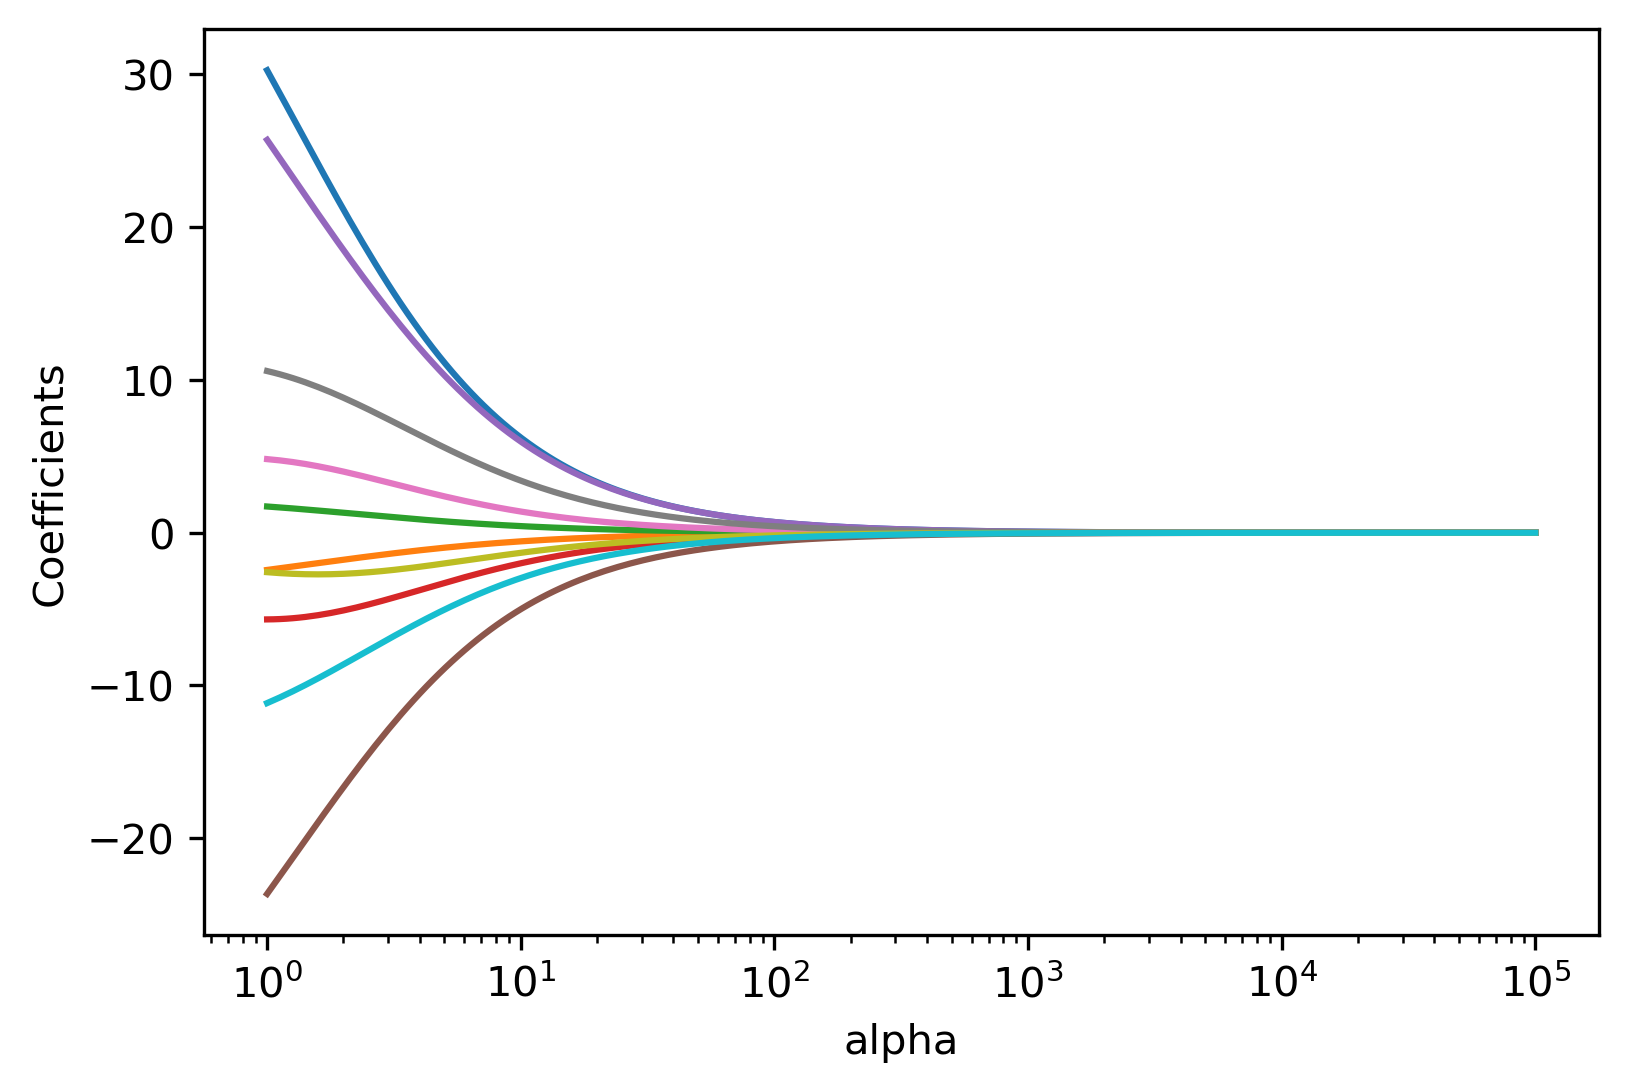

In [29]:


Y = bike_sharing_df.cnt
X = bike_sharing_df.loc[:].drop(columns=["cnt"])


# Count variable that we are going to be predicting
Y = bike_sharing_df.cnt
# Features that we are going to be fitting
X = bike_sharing_df.loc[:].drop(columns=["cnt"])

# Split the data
X_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.33, random_state = 1)

n_folds = 5
n_alphas = 200
# 0-5 because of negative logs
alphas = np.logspace(0, 5, n_alphas) #grid search for lambda (aka 'alpha')

parameters = { 'ridge__alpha':alphas}

scaler = StandardScaler()
ridge = Ridge(normalize=True,tol=2,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, ridge)

gs = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)
gs.fit(X_train,y_train)

alphas = np.logspace(0, 5, n_alphas) #grid search for lambda (aka 'alpha')

coefs = []
# print(pipe.get_params().keys()) #reports input names can set (look for the hyper-parameters)
parameters = {'ridge__alpha':alphas}
# model = GridSearchCV(pipe, parameters, scoring='neg_mean_squared_error', cv=n_folds)
# model.fit(X_train,y_train)
for a in alphas:
    pipe.set_params(ridge__alpha=a)
    pipe.fit(X_train, y_train)
    coefs.append(pipe.named_steps['ridge'].coef_)

plt.figure()
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')

plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Coefficients');



In [30]:
# coefficients {𝛽1,…,𝛽𝑝} for the last fitted model in the above for loop
pipe.named_steps['ridge'].coef_

array([ 7.08540001e-04, -6.69621305e-05,  5.15881969e-05, -2.50577683e-04,
        7.14299673e-04, -5.73946929e-04,  1.63413184e-04,  4.34081941e-04,
       -1.80362418e-04, -3.61040418e-04])

In [31]:
# B0
pipe.named_steps['ridge'].intercept_

188.19144550373616

In [32]:
# Average of Y's
np.mean(y_train)

188.19144550373616

In [33]:
# Best alpha
best_alpha = gs.best_params_['ridge__alpha']
print(best_alpha)

1.0


In [34]:
scaler = StandardScaler()
ridge = Ridge(alpha=best_alpha,normalize=False,fit_intercept=True) #we will pass through alpha values later
pipe = make_pipeline(scaler, ridge)
pipe.fit(X_train, y_train)

best_coef_ridge = pipe.named_steps['ridge'].coef_



# print('The final set of coefficients: ')
print(best_coef_ridge)

[ 52.3078546   -4.27575398   1.70068701  -0.68029894  52.57776887
 -42.59597605   1.87349968   6.63280273   1.60675934 -11.16571813]


In [35]:
print('\nCoefficients  [ridge]')
for i in range(0,10):
    print('   Feature %f:  %.2f'%(i,\
                    best_coef_ridge[i]))


Coefficients  [ridge]
   Feature 0.000000:  52.31
   Feature 1.000000:  -4.28
   Feature 2.000000:  1.70
   Feature 3.000000:  -0.68
   Feature 4.000000:  52.58
   Feature 5.000000:  -42.60
   Feature 6.000000:  1.87
   Feature 7.000000:  6.63
   Feature 8.000000:  1.61
   Feature 9.000000:  -11.17


In [36]:
y_pred = pipe.predict(x_test)

# This is where we were normalizing our predictions to try and calculate the RMSLE to compare with the kaggle competition
# scaled_y_pred = NormalizeData(y_pred)
# scaled_y_test = NormalizeData(y_test)  
# RMSLE, does not work due to negative values. 

# rmsle_test_using_ridge = np.sqrt( mean_squared_log_error(y_test,y_pred))
# print(mse_test_using_coef_true)
# print('\nTest set RMSLE using ridge coefficients: %.2f'%rmsle_test_using_ridge)
mse_test_using_ridge = mean_squared_error(y_test,y_pred)
# print(mse_test_using_coef_true)
print('\nTest set MSE using ridge coefficients: %.2f'%mse_test_using_ridge)


Test set MSE using ridge coefficients: 22840.26


In [37]:
lm = pipe

y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(x_test)

print('Train Score: ')
print(r2_score(y_train, y_train_pred))

print('\nTest Score: ')
print(r2_score(y_test, y_test_pred))

Train Score: 
0.3300808243670067

Test Score: 
0.3311748103422302
